# Linear Regression with Preprocessing Pipeline

Welcome to the second tutorial! In the last session, we briefly discussed supervised learning including the *regression* and *classification* problems. We then started our journey with a simple *linear regression* problem in which we trained a model to be able to predict the amount of energy that will be consumed given various factors.

We did this by first obtaining the data from Kaggle, splitting it into training and testing sets to prohibit *data leakage*, and scaling it to so that all the data was on the same level. We then setup a `LinearRegression` model that we trained on the training set and evaluated on the testing set.

However, for our feature data, we only took the *continuous* variables in the dataset. From this we saw that the `Temperature` feature had the most contribution to the energy consumed, by far. Now, we're going to add in all the rest of the features that we previous left out, then we can see if any other features contribute nearly as much as the temperature. 

So, let's get started! First, we're going to import all the libraries that we'll need. If you haven't already installed all the requirements, make sure to do this now:

In [31]:
## Uncomment this cell and run if you haven't already installed all the required libraries
#%pip install -r ../requirements.txt

In [32]:
## Import all the necessary libraries
import os
import torch
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

Now that we've imported everything, let's setup our data from Kaggle the same way we did in the previous tutorial.

# Setup

Here, we're going to get our data from Kaggle (if you haven't already done so in the previous tutorial), then convert it to a Pandas dataframe and split it into training and testing sets. Then we'll define our `LinearRegression` model that we'll train on the data, and we'll create functions for training and evaluation. These definitions will be just the same as what we used in the previous tutorial, except now we'll convert some of our work into convienent methods. 

## Data

Now, let's setup our data so that it'll be easy to view and work with all the features we want to use.

### Get dataset from Kaggle

To download the Kaggle dataset, you'll need a Kaggle API key. If you don't already have one, it's really simple to setup:

1.  Go to your [Kaggle account settings](https://www.kaggle.com/settings). Be sure to sign in if you haven't already done so. 
2.  Scroll down until you see the API settings.
3.  Click 'Create New Token' and save the `kaggle.json` file in the proper place:
    
    - For Windows: `C:\Users\{username}\.kaggle\kaggle.json`
    - For Linux: `/home/{username}/.kaggle/kaggle.json`
    - For Mac: `/Users/{username}/.kaggle/kaggle.json`

    where `{username}` is your username.

Now that you have your Kaggle API token setup, you'll be able to use it automatically within this notebook.

In [33]:
## Define file path to the data folder
file_path = '../../data'

In [34]:
## Create the data folder if it doesn't exist
if not os.path.exists(file_path):
    os.makedirs(file_path)

In [35]:
## Use Kaggle API to download the dataset to the data folder
!kaggle datasets download -d mrsimple07/energy-consumption-prediction -p ../../data

Dataset URL: https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction
License(s): apache-2.0
energy-consumption-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


### Extract dataset

In [36]:
## Extract the .csv file to the data folder
zip_file_path = os.path.join(file_path, 'energy-consumption-prediction.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)

### Create dataframe

In [37]:
## Load the data in a Pandas dataframe
df = pd.read_csv(os.path.join(file_path, 'Energy_consumption.csv'))
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In the previous tutorial, we only took the continuous variables for our training data (i.e. `Temperature`, `Humidity`, `SquareFootage`, `Occupancy`, and `RenewableEnergy`). Now, we'll see how to add in the rest of the features by properly preprocessing the data that's *categorical* (i.e. `HVACUsage`, `LightingUsage`, `DayofWeek`, and `Holiday`). We'll also extract the relevant properties from the `Timestamp` feature.

First, let's define all the methods that we'll use for training and evaluation. For a refresher on where these methods come from, check out the [previous tutorial](https://github.com/anima-kit/ai-notebooks/blob/main/00-ML/00-regression/00-basics.ipynb).

### Split data

In [38]:
## Split the data into training and testing sets
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

## Model

In [39]:
## Define the model using Pytorch
class LinearRegression:
    def __init__(self, features):
        # Initialize weights and bias as PyTorch tensors with gradients enabled
        # We need to be able to differentiate MSE w.r.t. all weights and bias
        self.features = features
        self.weights = torch.randn(len(features), requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    # Define how to predict the target variable    
    def forward(self, X):
        return X @ self.weights + self.bias

    # Define loss function to be minimized
    def loss(self, X, y):
        predictions = self.forward(X)
        return torch.mean((predictions - y) ** 2)
    
    # Define all parameters of model that MSE will be differentiated w.r.t.
    def parameters(self):
        return [self.weights, self.bias]

## Training

In [40]:
## Define function to train model
def train(X_train, y_train, model, num_epochs=1000, learning_rate=0.01):
    loss_history = []
    ## Training loop
    # For each epoch, calculate the loss, compute the gradients, then update the parameters
    for epoch in range(num_epochs):
        # Need to convert our data (Numpy arrays) into Pytorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)    
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        
        # Compute loss
        loss = model.loss(X_train_tensor, y_train_tensor)
        
        # Store loss for plotting
        loss_history.append(loss.item())
        
        # Compute gradients from loss function
        loss.backward()
        
        # Update parameters using gradient descent
        with torch.no_grad():
            model.weights -= learning_rate * model.weights.grad
            model.bias -= learning_rate * model.bias.grad
            
            # Zero the gradients for next iteration
            model.weights.grad.zero_()
            model.bias.grad.zero_()

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

    print("\nTraining completed!")
    return model, loss_history

## Evaluation

### Metrics

In [41]:
## Define function to evaluate the model after training
def evaluate(y_test, y_pred, model):
    ## Calculate metrics
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # R^2
    r2 = r2_score(y_test, y_pred)

    print("Model Evaluation:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    ## Print model parameters
    print("\nModel Parameters:")
    print(f"Weights: {model.weights.detach().numpy()}")
    print(f"Bias: {model.bias.item()}")

    ## Print the final model equation
    print("\nFinal Model Equation:")
    weights = model.weights.detach().numpy()
    features = model.features
    equation = f"y = "
    for i, (feature, weight) in enumerate(zip(features, weights)):
        if i == 0:
            equation += f"{weight:.4f} * {feature}"
        else:
            equation += f" + {weight:.4f} * {feature}"
    equation += f" + {model.bias.item():.4f}"
    print(equation)

### Plots

In [42]:
def eval_plots(y_test, y_pred, loss_history):
    ## Visualize results
    plt.figure(figsize=(12, 5))

    ## Training loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)

    ## Predictions vs Actual values
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)

    ## Perfect prediction
    x_range = [y_test.min(), y_test.max()]
    plt.plot(x_range, x_range, 'r-', lw=2, label='Perfect Prediction')

    ## ±10% from perfect prediction
    # Fill between the ±10% lines
    upper_line = [y_test.min()*1.1, y_test.max()*1.1]
    lower_line = [y_test.min()*0.9, y_test.max()*0.9]
    plt.fill_between(x_range, lower_line, upper_line, alpha=0.2, color='green', label='±10% Range')

    # Add the ±10% lines
    plt.plot(x_range, upper_line, 'g:', lw=1, alpha=0.7)
    plt.plot(x_range, lower_line, 'g:', lw=1, alpha=0.7)

    ## Mean lines
    plt.axvline(x=y_test.mean(), color='black', linestyle=':', alpha=0.75, label='Mean Actual')
    plt.axhline(y=y_pred.mean(), color='black', linestyle='--', alpha=0.75, label='Mean Predicted')

    ## Count points within 10% range
    within_10_percent = np.sum((y_pred >= 0.9 * y_test) & (y_pred <= 1.1 * y_test))
    percentage_within_10_percent = (within_10_percent / len(y_test)) * 100

    # Add text box with percentage
    plt.text(
        0.05, 0.95, f'Points within ±10%: {percentage_within_10_percent:.1f}%', 
        transform=plt.gca().transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual Values')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [43]:
## Plot weight importance
def weight_importance(model):
    feature_names = model.features
    importance = torch.abs(model.weights).detach().numpy()

    plt.figure(figsize=(10,5))
    plt.barh(feature_names, importance)
    plt.xticks(np.arange(round(min(importance)-0.1), round(max(importance)+0.1), 0.1))
    plt.title("Weight Importance")
    plt.xlabel("Weight")
    plt.grid(True)
    plt.show()

In [44]:
def correlation_matrix(X_train, y_train, model):
    ## Create dataframe from processed training data
    df = pd.DataFrame(X_train, columns=model.features)
    df['EnergyConsumption'] = y_train

    ## Calculate correlation matrix
    corr_matrix = df.corr()

    ## Plot correlation matrix
    # Notice we're rounding correlation coefficients to nearest decimal
    plt.figure(figsize=(8, 8))
    sns.heatmap(round(corr_matrix, 1), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [45]:
def permutation_importance(X_test, y_test, model):
    ## Calculate the MSE for predictions on the test set
    baseline_pred = model.forward(torch.FloatTensor(X_test)).detach().numpy()
    baseline_mse = mean_squared_error(y_test, baseline_pred)

    ## Loop through each feature
    importance_scores = []
    for i in range(X_test.shape[1]):
        # Copy the test data and shuffle the values for the feature
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        
        # Calculate the MSE for predictions with this new set of features
        permuted_pred = model.forward(torch.FloatTensor(X_permuted)).detach().numpy()
        permuted_mse = mean_squared_error(y_test, permuted_pred)

        # Importance is difference b/w MSE values
        importance = permuted_mse - baseline_mse
        importance_scores.append(importance)

    # Create feature importance dictionary
    feature_importance = dict(zip(model.features, importance_scores))
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and importance scores
    features, importances = zip(*sorted_features)

    # Create horizontal bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.barh(range(len(features)), importances)
    plt.xticks(np.arange(round(min(importances)-0.1), round(max(importances)+0.1), 0.1))
    plt.yticks(range(len(features)), features)
    plt.xlabel('MSE Difference')
    plt.title('Permutation Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Great, now that everything's defined, let's see how to deal with the rest of the data features.

# Preprocessing Example

Here, we're going to extract the relevant data from the `Timestamp` feature (`Month`, `Day`, `Hour`) and learn how to preprocess our categorial data through *one-hot* encoding.

## Prepare data

First, let's look at the time data. We can easily extract the day, month, and hour of the timestamp using Python's [datetime](https://docs.python.org/3/library/datetime.html) module. Notice that the year is the same for all timestamps, so we can safely ignore it here.

In [46]:
## Extract day, month, and hour from timestamp then add to our dataframe
months_col = []
days_col = []
hours_col = []
# Loop through each timestamp
for i in range(len(df['Timestamp'])):
    date_string = df['Timestamp'][i]
    # Turn the timestamp into a datetime object
    dt = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    # Extract the relevant features and append them to our lists
    months_col.append(dt.month)
    days_col.append(dt.day)
    hours_col.append(dt.hour)

# Add the new features to our dataframe
df['Month'] = months_col
df['Day'] = days_col
df['Hour'] = hours_col

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (1000, 14)
Columns: ['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday', 'EnergyConsumption', 'Month', 'Day', 'Hour']


Now, let's categorize each of the features into proper lists for easier preprocessing. We want a list for continuous features for which we'll scale the data just like in the previous tutorial, and we also want a list for categorical features. This list will contain all of our categorical features that we need to change into *numbers* so that we can properly use them in our regression model. Two ways of doing this are *ordinal* and *one-hot* encoding.

In ordinal encoding, the categories can clearly be ranked (such as `[Great, Average, Poor]` or `[A, B, C, D, F]`). In this case, the categories are turned into integers based on their ranking:

| Old value | New value |
| --------- | --------- |
| A         | 0         |
| B         | 1         |
| C         | 2         |
| D         | 3         |
| F         | 4         |

In our case, none of our categorical features seem to have any inherent ranking, so it may not be the best idea to use ordinal encoding (though perhaps it's worth testing). Instead, we can use one-hot encoding to turn our features into numbers. This is done by creating new columns for each of the possible categories of the feature. So, for example each day of the week in the `DayOfWeek` feature will be treated as an entirely new feature, and each data point will get a zero or one for the given day depending on which day the data point corresponds to:

| Energy Consumption | Mon | Tues | Wed | Thurs | Fri | Sat | Sun |
| ------------------ | --- | ---- | --- | ----- | --- | --- | --- |
| 75                 | 1   | 0    | 0   | 0     | 0   | 0   | 0   |
| 83                 | 0   | 0    | 0   | 0     | 0   | 1   | 0   |
| ...                | ... | ...  | ... | ...   | ... | ... | ... |

It's also common practice to *drop* one of the categories to reduce redundancy in the features. Using the example above, if we remove `Monday`, we can tell from the other categories that the first data point corresponds to a Monday and the second data point to a Saturday. Keeping the `Monday` feature just introduces an unecessary redundancy and model complication. This is even more obvious for our binary features which correspond to `Yes` or `No`, `On` or `Off`. We only need to keep one of these to explain the feature.

In [47]:
## Place each feature into its proper list
# Categorical features will be encoded with one-hot
onehot_features = ['DayOfWeek', 'HVACUsage', 'LightingUsage', 'Holiday']

# Numerical features will be scaled (like the previous tutorial)
continuous_features = [
    'Temperature', 
    'Humidity', 
    'SquareFootage', 
    'Occupancy', 
    'RenewableEnergy', 
    'Month', 
    'Day', 
    'Hour'
]

In [48]:
## Define the features dataset and the target
X = df.loc[:, continuous_features + onehot_features]
y = df["EnergyConsumption"]

print(f"Entire features dataset shape: {X.shape}")
print(f"Features used: {X.columns.tolist()}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

Entire features dataset shape: (1000, 12)
Features used: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'Month', 'Day', 'Hour', 'DayOfWeek', 'HVACUsage', 'LightingUsage', 'Holiday']
Target range: [53.26, 99.20]


In [49]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = split(X, y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 800
Test set size: 200


Now, we can use scikit-learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to easily define all the preprocessing steps that need to be taken to prepare our feature data. We define a `StandardScaler` for the numerical features just as we did in the previous tutorial, and we define a `OneHotEncoder` to one-hot encode all the categorical features while dropping the first category that appears for each feature.

Recall from the previous tutorial that we scaled our training data and used the resulting values to scale our test data in order to prevent data leakage. Here, we'll do the same thing - we preprocess the train data and use the results for the test data.

In [50]:
## Create preprocessing transformer for all feature data
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features - scale
        ('num', StandardScaler(), continuous_features),
        
        # Categorical features - one-hot encode
        ('onehot', OneHotEncoder(drop='first'), onehot_features)
    ],
    remainder='passthrough'
)

## Create a separate scaler for the target variables
scaler_y = StandardScaler()

## Fit and transform the training data
# Fit preprocessor to training features
X_train_processed = preprocessor.fit_transform(X_train)
# Then transform test features with this fit
X_test_processed = preprocessor.transform(X_test)

# Similarly for the target variables
y_train_processed = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_processed = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"\nAfter preprocessing")
print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")


After preprocessing
Training set shape: (800, 17)
Test set shape: (200, 17)


Ok, our data is all ready to be used for training and evaluation. Let's see how this model does compared to our previous one. 

## Train

For convience, let's cleanup the feature names after preprocessing.

In [51]:
## Extract the feature names from the preprocessor
feature_names = [name.split("__")[-1] for name in preprocessor.get_feature_names_out()]
feature_names

['Temperature',
 'Humidity',
 'SquareFootage',
 'Occupancy',
 'RenewableEnergy',
 'Month',
 'Day',
 'Hour',
 'DayOfWeek_Monday',
 'DayOfWeek_Saturday',
 'DayOfWeek_Sunday',
 'DayOfWeek_Thursday',
 'DayOfWeek_Tuesday',
 'DayOfWeek_Wednesday',
 'HVACUsage_On',
 'LightingUsage_On',
 'Holiday_Yes']

Now we can create our `LinearRegression` model which depends on all our features.

In [52]:
## Create model instance
model = LinearRegression(features=feature_names)

# Notice that weights should include 17 features
print(f"Model parameters")
print(f"Weights shape: {model.weights.shape}")
print(f"Bias shape: {model.bias.shape}")

Model parameters
Weights shape: torch.Size([17])
Bias shape: torch.Size([1])


Now let's train!

In [53]:
## Define Hyperparameters
learning_rate = 0.01
num_epochs = 1000

model, loss_history = train(
    X_train=X_train_processed, 
    y_train=y_train_processed, 
    model=model, 
    num_epochs=num_epochs, 
    learning_rate=learning_rate
)

Epoch [100/1000], Loss: 1.585023
Epoch [200/1000], Loss: 0.989627
Epoch [300/1000], Loss: 0.729141
Epoch [400/1000], Loss: 0.590830
Epoch [500/1000], Loss: 0.514173
Epoch [600/1000], Loss: 0.470296
Epoch [700/1000], Loss: 0.444343
Epoch [800/1000], Loss: 0.428410
Epoch [900/1000], Loss: 0.418189
Epoch [1000/1000], Loss: 0.411289

Training completed!


And that's it, our model is trained! Now, we should see how it does on our testing set.

## Evaluate

In [54]:
## Make predictions on test set
# Convert our data to a Pytorch tensor
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
# Make predictions using the model's `forward` method
y_pred_scaled = model.forward(X_test_tensor)

# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.detach().numpy().reshape(-1, 1)).flatten()

In [55]:
## Calculate metrics
evaluate(y_test, y_pred, model)

Model Evaluation:
Root Mean Squared Error (RMSE): 5.4405
R² Score: 0.5481

Model Parameters:
Weights: [ 0.7004341  -0.03057521 -0.02600084  0.19738676  0.10561883  0.04393448
  0.02534124 -0.02179191  0.53998804  0.42411005  0.4177197   0.6227785
  0.5051339   0.5500009   0.49168128  0.17230546  0.03374422]
Bias: -0.7686516642570496

Final Model Equation:
y = 0.7004 * Temperature + -0.0306 * Humidity + -0.0260 * SquareFootage + 0.1974 * Occupancy + 0.1056 * RenewableEnergy + 0.0439 * Month + 0.0253 * Day + -0.0218 * Hour + 0.5400 * DayOfWeek_Monday + 0.4241 * DayOfWeek_Saturday + 0.4177 * DayOfWeek_Sunday + 0.6228 * DayOfWeek_Thursday + 0.5051 * DayOfWeek_Tuesday + 0.5500 * DayOfWeek_Wednesday + 0.4917 * HVACUsage_On + 0.1723 * LightingUsage_On + 0.0337 * Holiday_Yes + -0.7687


Notice this $R^2$ value is significantly better than our previous model (i.e. $0.495$). However, our bias is pretty large which could point to *underfitting*. Let's discuss what this means briefly.

Common problems with machine learning models are *underfitting* or *overfitting* the data. When a model underfits the data, it doesn't sufficiently capture variations in the data and can result in poor predictions on both the training data and other data it hasn't seen. In this case, it's typical for the model to remain relatively the same regardless of the data that it's fed. For linear regression models, it's also common to see a large bias if it underfits the data. This is because the bias is making up for all the contributions to the target variable that the features can't explain. 

On the other hand, when a model *overfits* the data, it fits the training data too well and does poorly on other data that it hasn't seen. This is a common problem for higher-order polynomial models which can be arbitrarily fit to the data that it's fed. These models tend to change drastically for different training data (because it's trying to fit the different data exactly) and tend to have low bias - the features explain the target variable too well so there's no room for unexplained contributions in the bias.

Let's look at a plot to visualize what this means:

![Underfitting and Overfitting Models](https://anima-kit.github.io/ai-notebooks/assets/underfit-and-overfit.png)

The model on the left clearly underfits the data. It wouldn't be able to predict many of the points very well and would need a large bias to explain variations in the data, while the model on the right is going through most of the points and curving in all the right places to fit this particular dataset. This model would typically have a small bias and would perform poorly on the test set. 

Now, let's look at our evaluation plots.

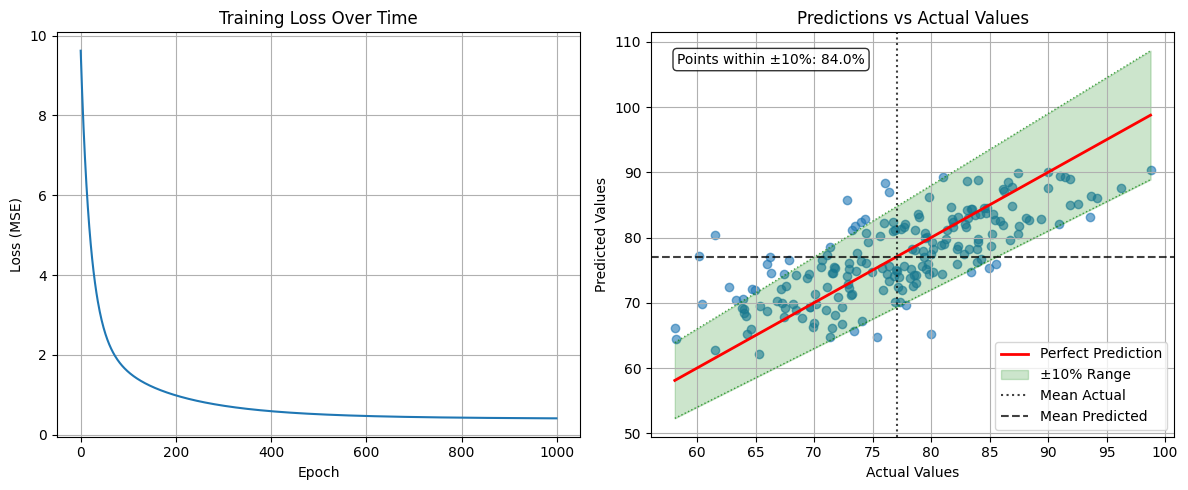

In [56]:
eval_plots(y_test, y_pred, loss_history)

Just like in our previous tutorial, this model also converges long before the end of training, but this time the convergence is slower (around $500$ instead of $200$ epochs). This makes sense when we consider that we have more parameters to optimize. 

The plot on the right shows the predicted and actual values along with $10\%$ ranges and the mean lines, just like previously. However, this time more of the data points fall within the $10\%$ range while our predicted mean is still a bit off compared to the actual mean. We could still improve this model!

Let's see what features are contributing the most to the total energy consumed.

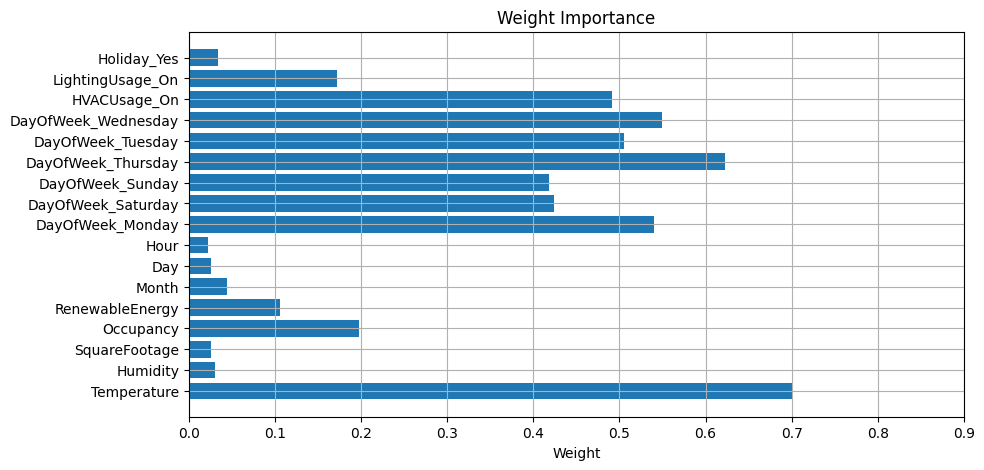

In [57]:
weight_importance(model)

Just like in the previous tutorial, the temperature contributes the most. But, this time the `HVACUsage` feature is in a close second. These two features do make the most sense in terms of what will contribute the most to energy consumed. We also see that many of the different days of the week are more or less on the same level, many of them are contributing more or less the same. This suggests that taking each day of the week (minus one) as a feature is a poor choice. Also, the month doesn't seem to contribute much, but intuitively it seems that it should as more extreme temperatures in the summers and winters typically result in more energy consumed. Perhaps this isn't the best way to represent this feature. 

Now, let's look at the correlation matrix.

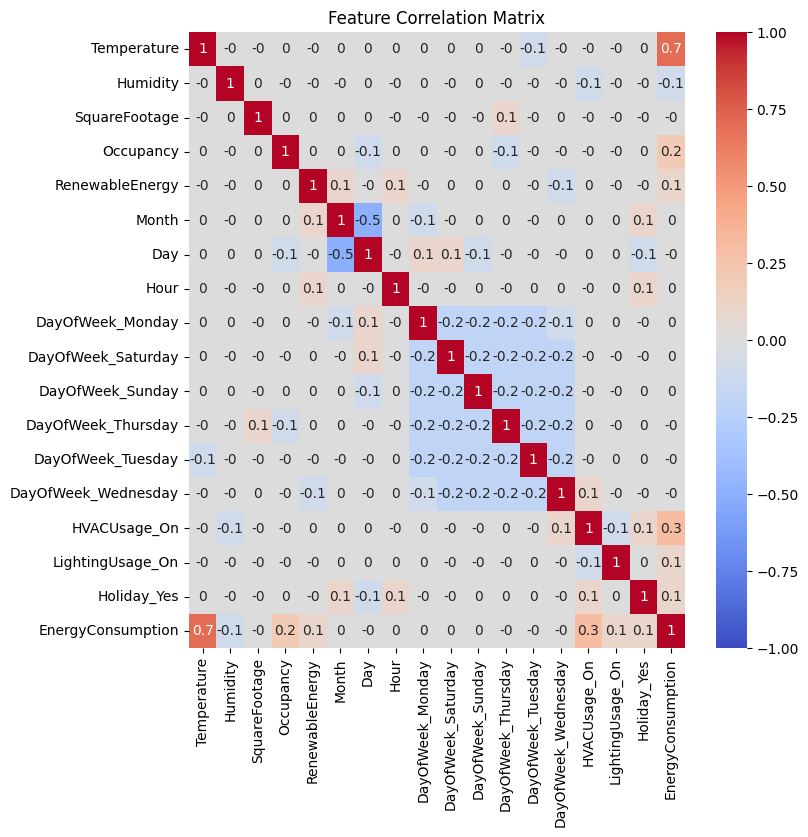

In [58]:
correlation_matrix(X_train_processed, y_train_processed, model)

It seems the temperature, humidity, occupancy, and renewable energy features have about the same correlations with the target as they did in the previous tutorial. However, now we have a somewhat strong correlation between the usage of HVAC and energy consumed and relatively small correlations between the lighting usage and whether or not it's a holiday. 

We also now have many correlations between *features*. This tends to show us where our features are redundant or where we should think about *engineering* them for better results. For example, each day of the week feature is correlated with each other. This seems to confirm our earlier suspicions that using each day of the week as a feature is poor engineering. We should instead think of how to better represent these features, perhaps by reducing them to a `Weekend` feature that denotes if it's a Saturday or Sunday, or by taking into account the cyclical nature of a week. 

There's also a very large negative correlation between the `Month` and `Day` parameters. This is an interesting point that shows why we need to understand the data we feed into our model. If we look at the the unique dates throughout the entire dataset, we'll see that the data only shows dates for January and February, while only about half of the month of February is recorded.

In [59]:
## Show unique months with minimum and maximum days recorded
df.groupby('Month')['Day'].agg(['min', 'max']).rename(columns={'min': 'min_day', 'max': 'max_day'})

,min_day,max_day
Month,,
1,1,31
2,1,11


This means that as month increases from 1 to 2, the total number of days decreases (because we only have half of month 2 recorded). This correlation is an artifact of how our data is presented and shows us that we should think more deeply about how to engineer the features we feed to our model, especially when given a small amount of biased data. We could potentially take into account the cyclical nature of the months in a year, but with only one and a half months recorded it seems that perhaps this feature won't be the most helpful for predicting energy consumption.

Finally, let's check out the permutation importance of each feature.

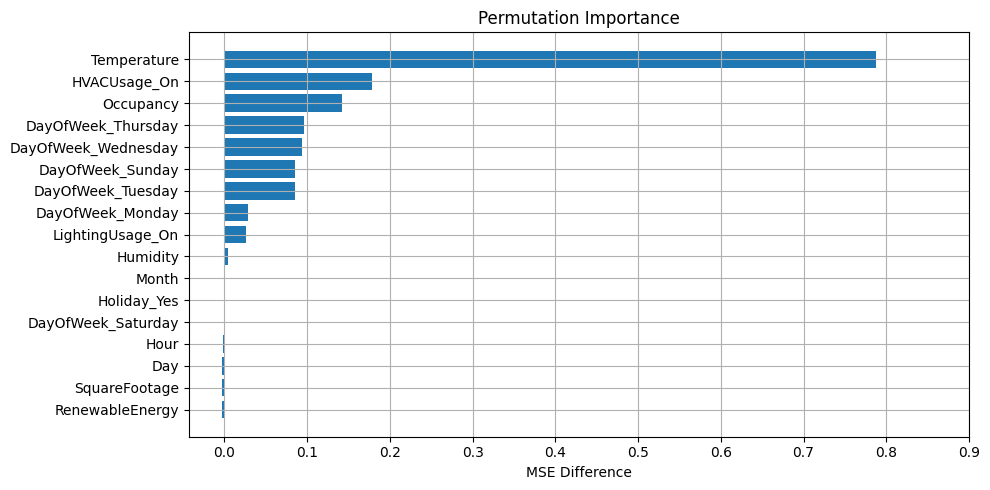

In [60]:
permutation_importance(X_test_processed, y_test_processed, model)

As expected, the temperature and HVAC usage have the most effect on accurate predictions with the occupancy having a slight effect and the other features being relatively unimportant. 

We've improved our previous linear regression model by adding in time and categorical features. We learned how to one-hot encode our categorical features and the imporance of choosing the right features to make up the model. 

In the next tutorial we'll check out how to do some *feature engineering* in which we choose features to better represent the predicted target. In this way we'll find that we can improve (or worsen) our model by adding new features that are combinations of others or transforming features to capture their cyclical nature.